Generating data...
  Min Eigenvalue: -2.60e-14
  [PASS] Matrix is PSD (Min eigenvalue >= -1e-08).

--- Training SVR with Custom PSD Kernel ---
MSE: 0.008275
R2 Score: 0.913866


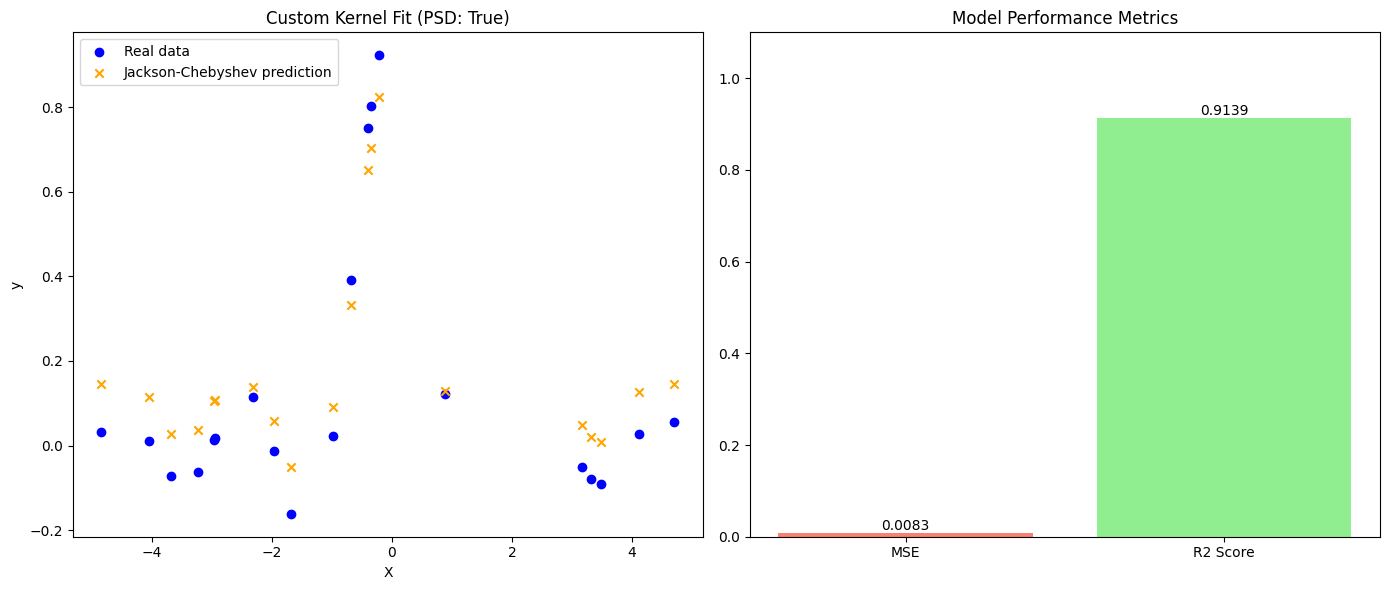

In [7]:
# -----------------------------------------------------------------------------
# Copyright (c) 2025 Renata Wong
#
# This code is supplementary material for the research paper:
# "Support Vector Machine Kernels as Quantum Propagators"
#
# Licensed under the MIT License.
# You may obtain a copy of the License at: https://opensource.org/licenses/MIT
# -----------------------------------------------------------------------------


import numpy as np
from scipy.linalg import eigh
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

class JacksonChebyshevKernel(BaseEstimator, TransformerMixin):
    """
    Implementation of Algorithm 1: Jackson-Chebyshev Spectral Kernel.
    
    This kernel approximates the Dirac delta function using a truncated 
    Chebyshev expansion, smoothed with Jackson coefficients to remove 
    Gibbs oscillations, and spectrally clipped to ensure positivity.
    """
    def __init__(self, degree=50, clip_eigen=True):
        self.degree = degree          # Degree of polynomial expansion (N)
        self.clip_eigen = clip_eigen  # Step 5: Spectral Clipping flag
        
        # State variables to store scaling parameters
        self.data_min_ = None
        self.data_max_ = None
        self.scale_scale_ = None
        self.scale_min_ = None
        self.jackson_coeffs_ = None

    def fit(self, X, y=None):
        """
        Prepare the kernel by learning the scaling and computing Jackson coefficients.
        """
        X = np.atleast_2d(X)
        
        # ---------------------------------------------------------------------
        # STEP 1: RESCALING (Learn parameters)
        # Algorithm 1 requires inputs in domain [-1, 1].
        # We learn the min/max from the training data here.
        # ---------------------------------------------------------------------
        self.data_min_ = np.min(X, axis=0)
        self.data_max_ = np.max(X, axis=0)
        
        # Add a buffer to ensure we stay strictly inside [-1, 1]
        # (Chebyshev polynomials are undefined at exactly |x| > 1)
        range_span = self.data_max_ - self.data_min_
        range_span[range_span == 0] = 1.0 # Handle constant features
        
        # We scale to [-0.95, 0.95] to be safe against outliers in test set
        self.scale_scale_ = 1.90 / range_span
        self.scale_min_ = self.data_min_
        
        # ---------------------------------------------------------------------
        # STEP 3: JACKSON SMOOTHING COEFFICIENTS
        # Compute the damping coefficients g_n once.
        # Formula: g_n = [(N-n+1)*cos(n*pi/(N+1)) + sin(n*pi/(N+1))*cot(pi/(N+1))] / (N+1)
        # ---------------------------------------------------------------------
        N = self.degree
        n = np.arange(N)
        theta = np.pi / (N + 1)
        
        sin_n = np.sin(n * theta)
        cos_n = np.cos(n * theta)
        cot_theta = 1.0 / np.tan(theta)
        
        self.jackson_coeffs_ = ((N - n + 1) * cos_n + sin_n * cot_theta) / (N + 1)
        
        return self

    def _transform_features(self, X):
        """
        Helper: Transform input data into Weighted Chebyshev Features.
        """
        X = np.atleast_2d(X)
        
        # ---------------------------------------------------------------------
        # STEP 1: RESCALING
        # Map X to [-1, 1]. We clip to [-0.999, 0.999] to prevent NaN errors.
        # ---------------------------------------------------------------------
        X_scaled = (X - self.scale_min_) * self.scale_scale_ - 0.95
        X_scaled = np.clip(X_scaled, -0.9999, 0.9999) # Robust fix for NaNs
        
        # ---------------------------------------------------------------------
        # STEP 2: CHEBYSHEV EXPANSION & STEP 3: SMOOTHING
        # Compute T_n(x) and weight them by sqrt(g_n).
        # Feature vector Phi(x) = [ sqrt(g_0)T_0(x), ..., sqrt(g_N)T_N(x) ]
        # ---------------------------------------------------------------------
        orders = np.arange(self.degree)
        sqrt_g = np.sqrt(self.jackson_coeffs_)
        
        feature_matrices = []
        n_features = X.shape[1]
        
        for d in range(n_features):
            x_col = X_scaled[:, d]
            
            # T_n(x) = cos(n * arccos(x))
            # Shape: (n_samples, degree)
            cheb_feats = np.cos(np.arccos(x_col)[:, None] * orders)
            
            # Apply Jackson Weights
            weighted_feats = cheb_feats * sqrt_g
            feature_matrices.append(weighted_feats)
            
        return feature_matrices

    def compute_kernel(self, X1, X2=None, is_training=False):
        """
        Computes the Gram Matrix.
        """
        if X2 is None: X2 = X1
        
        # Get features
        feats1_list = self._transform_features(X1)
        feats2_list = self._transform_features(X2)
        
        # ---------------------------------------------------------------------
        # STEP 4: GRAM MATRIX CONSTRUCTION
        # For multi-feature data, we use the Tensor Product kernel:
        # K(x, y) = Product_d ( Phi_d(x) . Phi_d(y) )
        # ---------------------------------------------------------------------
        n_samples_1 = X1.shape[0]
        n_samples_2 = X2.shape[0]
        K_final = np.ones((n_samples_1, n_samples_2))
        
        for d in range(len(feats1_list)):
            # Dot product of feature vectors for dimension d
            K_dim = feats1_list[d] @ feats2_list[d].T
            K_final *= K_dim
            
        # ---------------------------------------------------------------------
        # STEP 5: SPECTRAL CLIPPING
        # Only applied to the training kernel matrix to ensure it is PSD.
        # ---------------------------------------------------------------------
        if is_training and self.clip_eigen:
            # Eigendecomposition
            vals, vecs = eigh(K_final)
            
            # Clip negative eigenvalues (numerical noise)
            vals[vals < 0] = 0
            
            # Reconstruct Matrix
            K_final = vecs @ np.diag(vals) @ vecs.T
            
        return K_final

    # --- Sklearn Interface Methods ---
    def get_train_kernel(self, X_train):
        self.fit(X_train) # Learn scaling
        return self.compute_kernel(X_train, X_train, is_training=True)
    
    def get_test_kernel(self, X_train, X_test):
        # Compute Rectangular Kernel K(X_test, X_train)
        return self.compute_kernel(X_test, X_train, is_training=False)

def check_is_psd(K, tol=1e-8):
    """
    Test if a kernel matrix K is Positive Semi-Definite (PSD).
    """
    # 1. Check symmetry
    if not np.allclose(K, K.T, atol=tol):
        print(f"  [FAIL] Matrix is not symmetric (Max diff: {np.max(np.abs(K - K.T))})")
        return False

    # 2. Check eigenvalues
    vals = np.linalg.eigvalsh(K)
    min_eig = np.min(vals)
    
    print(f"  Min Eigenvalue: {min_eig:.2e}")
    
    if min_eig < -tol:
        print(f"  [FAIL] Matrix has negative eigenvalues (Not PSD).")
        return False
    else:
        print(f"  [PASS] Matrix is PSD (Min eigenvalue >= {-tol}).")
        return True

# =============================================================================
# MAIN EXECUTION WITH PSD TEST (ADJUST FOR YOUR PROBLEM)
# =============================================================================
if __name__ == "__main__":
    
    # 1. Generate Dummy Data (General Case)
    print("Generating data...")
    X = np.random.uniform(-5, 5, 100).reshape(-1, 1)
    y = np.sinc(X).ravel()
    
    # 2. Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 3. Instantiate Kernel
    kernel_clipped = JacksonChebyshevKernel(degree=60, clip_eigen=True)
    K_train_clipped = kernel_clipped.get_train_kernel(X_train)
    is_psd_clipped = check_is_psd(K_train_clipped)
    
    # 4. Use the Valid Kernel for SVR
    print("\n--- Training SVR with Custom PSD Kernel ---")
    K_test_clipped = kernel_clipped.get_test_kernel(X_train, X_test)
    
    svr = SVR(kernel='precomputed', C=10)
    svr.fit(K_train_clipped, y_train)
    
    # 5. Predict & Evaluate
    y_pred = svr.predict(K_test_clipped)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)  # Calculate R2 Score
    
    print(f"MSE: {mse:.6f}")
    print(f"R2 Score: {r2:.6f}")
    
    # 6. Plotting (Scatter Plot + Performance Bar Graph)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Subplot 1: Prediction vs Real Data
    ax1.scatter(X_test, y_test, color='blue', label='Real data')
    ax1.scatter(X_test, y_pred, color='orange', marker='x', label='Jackson-Chebyshev prediction')
    ax1.legend(loc='upper left')
    ax1.set_title(f"Custom Kernel Fit (PSD: {is_psd_clipped})")
    ax1.set_xlabel("X")
    ax1.set_ylabel("y")

    # Subplot 2: Bar Graph for Metrics
    metrics = ['MSE', 'R2 Score']
    values = [mse, r2]
    colors = ['salmon', 'lightgreen']
    
    bars = ax2.bar(metrics, values, color=colors)
    ax2.set_title("Model Performance Metrics")
    ax2.set_ylim(0, max(1.1, max(values) * 1.1)) 
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()